## Data Camp Project

# Credit Card Fraud Detection 

Authors:
  * Yuhe Bai
  * Jérôme Bonnin
  * Louis Mercier
  * Dan Allouche
  * Lotfi Kobrosly

## Table of contents

The number of credit card transactions are increasing in line
with technological developments and the rise of e-commerce. Although credit card payments facilitate all kinds of business activities, credit card fraud is a significant problem.

Credit card fraud not only brings huge economic losses to
financial institutions and banks, but also trouble and stress
to the lives of individuals who are affected. Recent statistics
show that, in 2018 the global economic loss caused by credit
card fraud was 27.85 billion dollars, an increase of 16.2%
compared with 23.97 billion dollars in 2017. If this trend
continues, by 2023 the economic losses caused by credit card
fraud will exceed 35 billion dollars...

The ratio of fraudulent transactions to normal transactions is approximately 0,006%
worldwide. Although this rate may seem insignificant, every
fraudulent transaction hurts the reputation of banks. For this
reason, banks are investing in fraud detection. The number of fraudulent activities and their methods increases and
changes every day. It is very difficult and costly to detect
fraudulent activities only by examining the transactions. Fast
and accurate fraud detection is crucial to maintain customer
satisfaction and trust. Therefore, banks need to identify these
transactions as quickly as possible and in the least harmful
way for the customer.


(Today, fraudulent activities using social engineering are
predominantly performed through Internet. Malware and
phishing methods are engineered for this purpose. Most popular types of fraud include customer information altering
through call center and branches, ATM fraud, credit card
application fraud, card account theft, lost-stolen, fake credit
cards and card duplication [3].)


The design of efficient fraud detection algorithms is key for reducing these losses, and more and more algorithms rely on advanced machine learning techniques to assist fraud investigators. 
In addition effective fraud detection applications can increase customer confidence and
reduce customer complaints. Most credit card fraud detection
approaches make use of machine learning, espetially supervised learning methods.

However, in
credit fraud situations, the number of positive (fraudulent)
cases is much smaller than the number of negative cases.
This creates a problem of imbalanced classification, where
one class is very much smaller than the other class.

## Imports

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [11]:
df = pd.read_csv('creditcard.csv')
print('The data frame has {} rows and {} columns.'.format(df.shape[0], df.shape[1]))

The data frame has 284807 rows and 31 columns.


In [34]:
# Check if the data is clean
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

Researchers have proposed many measurement metrics to
detect the performance of imbalanced classification models.
These metrics include recall rate [17], [38], specificity [17],
precision [17], [38], F-measure [17], [38], and accuracy. In
this paper, we focus on two indicators: precision and Fmeasure. In credit card fraud, these are considered the most
important indicators. Precision is the ratio of the number of
real positive cases and the number of predicted positive cases.
In the detection of credit card fraud, the first goal is to provide
the maximum truth, that is, the highest precision. In practice,
a false alarm can lead to a poor customer experience, and
potentially lead to the loss of customers, so the precision
of the model is very important, and is considered the most
important indicator of the fraud system. On the other hand,
although precision can be increased by reducing the model’s
recall rate, it is impossible to improve the precision by
reducing the recall rate without limitation. Recall rate is
the ratio of the number of predicted positive cases to the
number of all real positive cases. Real fraud problems have
real negative economic implications to the enterprise, so the
recall rate is also worthy of our attention. Another indicator
is the F-measure, which takes values on the range [0,1].
The F-measure captures both the precision and recall rate,
measuring improvements in both indicators simultaneously.
In machine learning, this index is often used to evaluate the
advantages and disadvantages of various algorithms, because
it can evaluate the precision and recall rate in combination.
Accuracy is a commonly used indicator, which represents the
proportion between the number of correctly classified cases
and the total number of cases. If the accuracy of a model
is too low, it cannot be applied in practice. Specificity is
the ratio of the number of predicted negative cases predicted
to be negative to the number of real negative cases. In the
experiment, we consider these five indicators to measure the
performance of the model.


### An unbalanced problem

In [49]:
df_1 = data[data.Class == 1]
df_0 = data[data.Class == 0]

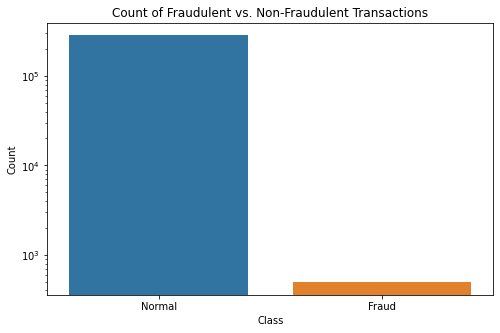

In [53]:
counts = df.Class.value_counts()
plt.figure(figsize=(8,5))
sns.barplot(counts.index, counts)
plt.title('Count of Fraudulent vs. Non-Fraudulent Transactions')
plt.ylabel('Count')
plt.xlabel('Class')
plt.xticks(range(2), ['Normal', 'Fraud'])
plt.yscale('log')
plt.show()

In [30]:
print('There are {} non-fraudulent transactions ({:.3f}%) and {} fraudulent transactions ({:.3f}%).'.format(counts[0], counts[0] * 100 / df.shape[0], counts[1], counts[1] * 100 / df.shape[0]))

There are 284315 non-fraudulent transactions (99.827%) and 492 fraudulent transactions (0.173%).


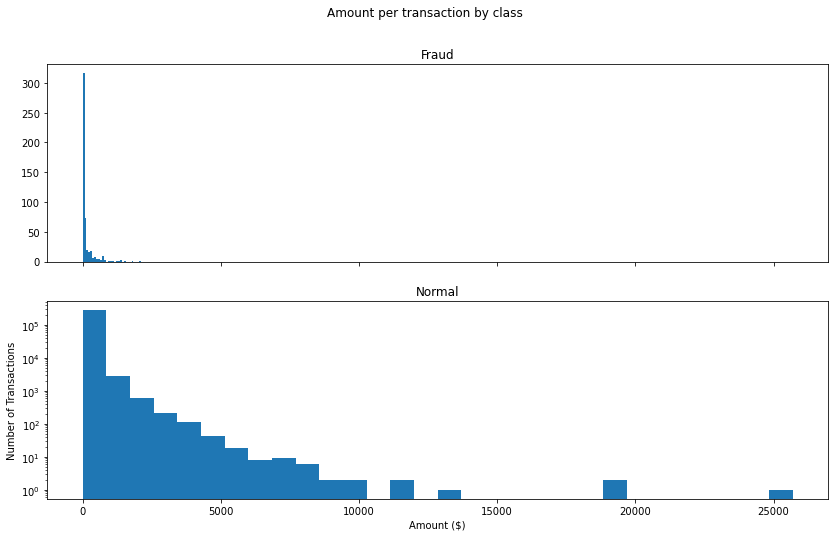

In [56]:
f, axs = plt.subplots(2, 1, sharex=True, figsize=(14,8))
f.suptitle('Amount per transaction by class')
bins = 30
axs[0].hist(df_1.Amount, bins = bins)
axs[0].set_title('Fraud')
axs[1].hist(df_0.Amount, bins = bins)
axs[1].set_title('Normal')
plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
plt.yscale('log')
plt.show()